<a href="https://colab.research.google.com/github/prtk0007/Chest_Xray_detection/blob/exp_binary/scratch_cnn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# # !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
!unzip \*.zip

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
train_path = '/content/train'
test_path = '/content/test'
valid_path = '/content/val'

In [4]:

#Define standard parameter values
batch_size = 32
img_height = 500
img_width = 500


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [23]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [24]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dropout(0.3))
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dropout(0.1))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 58, 58, 64)       

In [26]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00001)

callbacks_list = [ early, learning_rate_reduction]

In [27]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [28]:
cnn.fit(train,epochs=20, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/20
262/262 [==============================] - 134s 510ms/step - loss: 0.6180 - accuracy: 0.5674 - val_loss: 0.4518 - val_accuracy: 0.7721
Epoch 2/20
262/262 [==============================] - 132s 505ms/step - loss: 0.2873 - accuracy: 0.8692 - val_loss: 0.2786 - val_accuracy: 0.8712
Epoch 3/20
262/262 [==============================] - 132s 504ms/step - loss: 0.2288 - accuracy: 0.8969 - val_loss: 0.2479 - val_accuracy: 0.8875
Epoch 4/20
262/262 [==============================] - 132s 504ms/step - loss: 0.2210 - accuracy: 0.9044 - val_loss: 0.1984 - val_accuracy: 0.9183
Epoch 5/20
262/262 [==============================] - 133s 508ms/step - loss: 0.2118 - accuracy: 0.9119 - val_loss: 0.1926 - val_accuracy: 0.9144
Epoch 6/20
262/262 [==============================] - 132s 502ms/step - loss: 0.1866 - accuracy: 0.9247 - val_loss: 0.2039 - val_accuracy: 0.9096
Epoch 7/20
262/262 [==============================] - 132s 502ms/step - loss: 0.1924 - accuracy: 0.9112 - val_loss: 0.2978 -

In [34]:
cnn.evaluate(train)

262/262 [==============================] - 110s 418ms/step - loss: 0.1063 - accuracy: 0.9594


[0.10625752061605453, 0.9594465494155884]

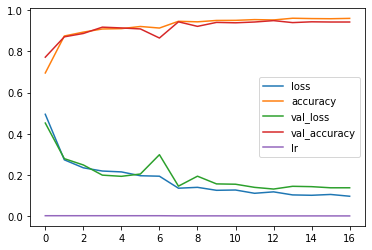

In [29]:
pd.DataFrame(cnn.history.history).plot()

In [30]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 6s 158ms/step


In [31]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

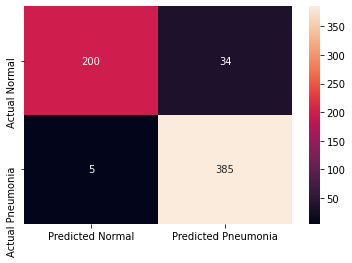

In [32]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [33]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.98      0.85      0.91       234
   PNEUMONIA       0.92      0.99      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624

